<a href="https://colab.research.google.com/github/MarkLimmage/GrapheneOxideClustering/blob/main/Object_Recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognising Objects in Sea Floor Images

First the training images need to be collated into a single folder

In [ ]:
# Load some libraries
import os
import shutil
import pandas as pd
from tqdm import tqdm # progress bar
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:

def get_filepaths(directory):

    file_names = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for dir, directories, files in os.walk(directory, topdown=False):
        for file in files:
          path = os.path.join( dir, file)
          file_names.append(path)  # Add it to the list.
          
    return file_names

# Run the above function and store its results in a variable.
full_names = get_filepaths("/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/BB")



dict = {'path': full_names}
df = pd.DataFrame(dict)

# saving the dataframe
# df.to_csv('/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/test.csv')

# now copy the files into a single folder


def copy_files():
    root = "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/BB"
    for index, row in df.iterrows():
      try:
        if( (row['path'].split("/")[10] != '.DS_Store') & (row['path'].split("/")[10] != '.ipynb_checkpoints') ) :
          file_name = row['path'].split("/")[10]
          new_path = os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/train", file_name)
          old_path = row['path']
          shutil.copy(old_path,new_path)
      except:
        print('ouch')

#copy_files()

drop_list = []
for index, row in df.iterrows():
  if( row['path'][-10:] == '/.DS_Store'):
    drop_list.append( index )
    
df = df.drop(drop_list)
df


,path
1,/content/drive/MyDrive/Colab Notebooks/MA5854_...
2,/content/drive/MyDrive/Colab Notebooks/MA5854_...
3,/content/drive/MyDrive/Colab Notebooks/MA5854_...
4,/content/drive/MyDrive/Colab Notebooks/MA5854_...
5,/content/drive/MyDrive/Colab Notebooks/MA5854_...
...,...
186,/content/drive/MyDrive/Colab Notebooks/MA5854_...
187,/content/drive/MyDrive/Colab Notebooks/MA5854_...
189,/content/drive/MyDrive/Colab Notebooks/MA5854_...
190,/content/drive/MyDrive/Colab Notebooks/MA5854_...


In [ ]:
# Set some variables
%cd /content

ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV"
IMAGE_DIR = "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/train"  # directory to save images
LABEL_DIR = "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/labels"  # directory to save labels

FOLD = 0  # which fold to train
DIM = 640
MODEL = "yolov5x"
BATCH = 16
EPOCHS = 15
OPTMIZER = "SGD"

PROJECT = "object-identification"  # w&b in yolov5
NAME = f"{MODEL}-dim{DIM}-fold{FOLD}"  # w&b for yolov5




/content


## Construct a training dataset df
File names will correspond to the names in the labelling files. Images were labelled using https://www.makesense.ai/. Label outputs were downloaded in VOC xml, YOLO txt and csv formats. These have been saved into the labels fodler in inputs. 



In [ ]:
# Train Data
df2 = pd.read_csv(f"{ROOT_DIR}/input/labels/labels.csv", names=['labels','x_corner', 'y_corner','ob_width','ob_height', 'file','im_width','im_height' ] )
df2["label_path"] = f"{LABEL_DIR}/YOLO_TXT/" + df2.file.str.replace("jpg", "txt")
df2["image_path"] = f"{IMAGE_DIR}/" + df2.file
df2.head(5)

,labels,x_corner,y_corner,ob_width,ob_height,file,im_width,im_height,label_path,image_path
0,metal_bar,1968,841,98,73,image_D2022-01-24T00-03-30-143223Z_1.jpg,4096,2304,/content/drive/MyDrive/Colab Notebooks/MA5854_...,/content/drive/MyDrive/Colab Notebooks/MA5854_...
1,misc_object,2367,1445,111,62,image_D2022-01-24T00-03-30-143223Z_1.jpg,4096,2304,/content/drive/MyDrive/Colab Notebooks/MA5854_...,/content/drive/MyDrive/Colab Notebooks/MA5854_...
2,misc_object,2365,1046,97,47,image_D2022-01-24T00-03-30-143223Z_1.jpg,4096,2304,/content/drive/MyDrive/Colab Notebooks/MA5854_...,/content/drive/MyDrive/Colab Notebooks/MA5854_...
3,misc_object,2267,1053,87,62,image_D2022-01-24T00-03-30-143223Z_1.jpg,4096,2304,/content/drive/MyDrive/Colab Notebooks/MA5854_...,/content/drive/MyDrive/Colab Notebooks/MA5854_...
4,misc_object,2088,1217,81,63,image_D2022-01-24T00-03-30-143223Z_1.jpg,4096,2304,/content/drive/MyDrive/Colab Notebooks/MA5854_...,/content/drive/MyDrive/Colab Notebooks/MA5854_...


# Explore the data
Take a look at the distribution of classes.

There are 184 images, 648 objects and 26 classes.


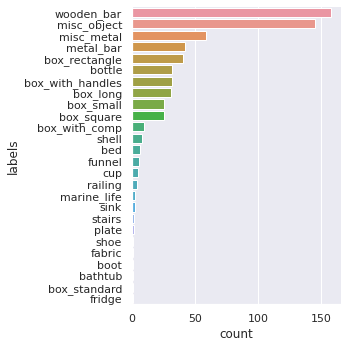

In [ ]:
# Get the labels

classes = df2.labels.unique()

print('There are ' + str(len(df)) + ' images, ' + str(len(df2)) + " objects and " + str(len(classes)) + ' classes.')

sns.set_theme(style="darkgrid")
ax1 = sns.catplot(y="labels", 
                  data=df2, kind="count", 
                  order = df2['labels'].value_counts().index )




## Augmenting training data
Ideally the training data set should be augmented such that the distribution of classes is uniform. The strategy will be based on the following considerations.

1.   Create the training dataset by copying images and labels into the train folders. 
2.   To create a more uniform class distribution, use augmentation to increase the number of images containing particular objects.
3.   Move 15% of training images and labels to the validation folders.

Since many of the images contain multiple different objects classes, without careful selection of images to augment, the resulting class distribution will not be perfectly uniform. Initially, this won't be considered, but the distribution can be checked following the process.
 



In [ ]:
aug_reqs = {
    "count":df2['labels'].value_counts(), 
    "factor": max(df2['labels'].value_counts())/df2['labels'].value_counts()}
aug_reqs = pd.DataFrame(aug_reqs)
aug_reqs['factor'] = round(aug_reqs['factor'])-1
aug_reqs

,count,factor
wooden_bar,158,0.0
misc_object,145,0.0
misc_metal,59,2.0
metal_bar,42,3.0
box_rectangle,41,3.0
bottle,32,4.0
box_with_handles,32,4.0
box_long,31,4.0
box_small,26,5.0
box_square,26,5.0


In [ ]:
# make the local data set dir structure

!mkdir -p datasets
!mkdir -p datasets/train
!mkdir -p datasets/train/images
!mkdir -p datasets/train/labels
!mkdir -p datasets/valid
!mkdir -p datasets/valid/images
!mkdir -p datasets/valid/labels

## Use Albumentations
Albumentations allows for control over image augmentation

In [ ]:
# Install required libraries
!pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install -U albumentations --no-binary qudida,albumentations

!pip uninstall opencv-python-headless==4.5.5.64
!pip install opencv-python-headless==4.5.2.52



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1w87qsle
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1w87qsle
     |████████████████████████████████| 47.8 MB 1.7 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=331dace14c56ac36df44314bdad7382ef132194b466119a219c96ff2489d1582
  Stored in directory: /tmp/pip-ephem-wheel-cache-tbtv_6rz/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove

In [ ]:
import albumentations as A
import cv2

In [ ]:
yolo_labels = get_filepaths("/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/labels/YOLO_TXT")
yolo_labels = pd.DataFrame(yolo_labels, columns=['file'])
label_df = pd.DataFrame(columns=['file','class','x_center','y_center','width','height'])
for index, file in yolo_labels.iterrows():
  y_file = pd.read_csv(file.file, sep=" ", header=None, names=['class','x_center','y_center','width','height'])
  y_file['file'] = file.file.split("/")[9].split(".")[0]+'.jpg'
  label_df = label_df.append(y_file)

label_df['px_width'] = label_df['width'].apply(lambda x: x * 4096 )
label_df['px_height'] = label_df['height'].apply(lambda y: y * 2304 )
label_df['x_corner'] = label_df['x_center'].apply(lambda x: x * 4096 ) - label_df['px_width'].apply(lambda x: x * 0.5 )
label_df['y_corner'] = label_df['y_center'].apply(lambda y: y * 2304 ) - label_df['px_height'].apply(lambda x: x * 0.5 )

# Now match the yolo int labels with class names from the csv
class_names = pd.DataFrame()
for index, row in label_df.iterrows():
  names = df2[
      (df2['file'] == row['file'] ) &
      (abs(df2['x_corner'] - row['x_corner']) < 3)
      ]['labels']
  for labels in names.iteritems():
    class_names=class_names.append( {'label':labels[1], 'class':row['class'] }, ignore_index=True )

object_dict = class_names.drop_duplicates().sort_values('class')




In [ ]:
n=len(object_dict)
names={}
m = int(max(object_dict['class']))
for i in range(0,m+1):
  try:
    names[i] = object_dict.loc[(object_dict['class'] == float(i), 'label')].iloc[0]
  except:
    names[i] = 'na'
  
names



dict

In [ ]:
# Create some helper function

transform = A.Compose([
    A.Affine(scale=1, 
             translate_px={'x':[10,100], 'y':[10,50]}, 
             rotate=None, 
             shear=None, 
             interpolation=1, 
             mask_interpolation=0, 
             cval=0, 
             cval_mask=0, 
             mode=0, 
             fit_output=False, 
             always_apply=True, p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),], 
    bbox_params=A.BboxParams(
        format='yolo', 
        min_area=0.0, 
        min_visibility=0.5,
        label_fields=names
         )
    )

def apply_augmentation(image, bboxes, class_labels):
  transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
  return transformed



In [ ]:


import yaml

data = [{
    'train' : '../datasets/train/images/',
    'val' : '../datasets/val/images/',
    'nc' : 28,
    'names' : names
     } ]

with open('data.yml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [ ]:
boxes.loc[:,1:4].to_dict(orient="list")

{1: [0.670455], 2: [0.385281], 3: [0.092532], 4: [0.141414]}

In [ ]:
objects = pd.DataFrame( columns=['object','file', 'ob_count', 'other_obs'])
for label, factor in aug_reqs.iterrows():
  
  if(label == 'box_with_handles'):
    # Copy the original training images and their labels to the datasets folders
    files = df2.loc[df2['labels'] == label]['file']
    n=0
    for file in files:
      train_file = file.split(".")[0] + ".txt"
      old_image_path = os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/train", file)
      old_label_path = os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/labels/YOLO_TXT", train_file)
      train_image_path = os.path.join( "/content/datasets/train/images", file)
      train_label_path = os.path.join( "/content/datasets/train/labels", train_file)
      shutil.copy(old_image_path,train_image_path)
      shutil.copy(old_label_path,train_label_path)      
      n=n+1

    # Get a list of the files containing the object, the number of occurances of 
    # the object in the image and the number of other objects in each image.
    files = df2.loc[df2['labels'] == label]['file'].unique()
    for file in files:
      count = len(df2[(df2['file'] == file) & (df2['labels'] == label)])
      other_obs = len(df2[(df2['file'] == file) & (df2['labels'] != label)])
      objects = objects.append({'object':label,'file':file,'ob_count':count, 'other_obs':other_obs}, ignore_index=True)
    
    # Iterate through the files containing less than 2 other objects and copy
    # augmentations of those images and their labels to the datasets folders
    # until number of objects in the datasets > target
    objects = objects[objects['other_obs'] < 2 ]
    target = 158
    while n < target:
      for index, row in objects.iterrows():
        n = n + row['ob_count']
        if(n > target):
          break        
        name = row['file'].split(".")[0]
        file_path = os.path.join( "/content/datasets/train/images", name +".jpg")
        bboxes = os.path.join( "/content/datasets/train/labels", name +".txt")
        # Augment the image and its label
        image = cv2.imread(file_path)
        boxes = pd.read_csv(bboxes, sep=' ', header=None )
        bboxes = boxes.loc[:,1:4].to_numpy()
        class_labels = boxes[0].to_dict()
        # Add labels to the bboxes
        #apply_augmentation
        transformed = apply_augmentation(image, bboxes, class_labels)
        np.savetxt( os.path.join( "/content/datasets/train/labels", name + "_aug_" + n + ".txt"), transformed['bboxes'].values, fmt='%d')
        cv2.imwrite( os.path.join( "/content/datasets/train/images", name + "_aug_" + n + ".jpg"), transformed['image'] )





ValueError: ignored

In [ ]:
boxes = pd.read_csv('/content/datasets/train/labels/image_D2022-01-23T08-30-20-253616Z_1.txt', sep=' ', header=None )
boxes[0]

0    7
1    3
2    1
Name: 0, dtype: int64

# Install YOLOv5

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
from IPython.display import Image, clear_output
display = utils.notebook_init()  # checks



YOLOv5 🚀 v6.1-207-g5774a15 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.7/78.2 GB disk)
